<a href="https://colab.research.google.com/github/MrPrabhathPeri/Audio-Gender-Prediction/blob/main/Audio_Gender_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install librosa numpy tensorflow matplotlib scikit-learn


In [2]:
# Clone the dataset from GitHub
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# Navigate to the recordings folder
import os

dataset_path = '/content/free-spoken-digit-dataset/recordings/'
audio_files = os.listdir(dataset_path)
print(f"Number of audio files: {len(audio_files)}")


Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 23.36 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Number of audio files: 3000


In [3]:
import librosa
import numpy as np
import pandas as pd

# Preprocessing function
def preprocess_audio(file_path, sr=16000):
    # Load audio file
    y, _ = librosa.load(file_path, sr=sr)
    # Trim silence
    y, _ = librosa.effects.trim(y)
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)  # Use mean of MFCCs

# Create dataset with labels
data = []
labels = []
for file in audio_files:
    if file.endswith('.wav'):
        file_path = os.path.join(dataset_path, file)
        # Gender label: 'jackson' and 'nicolas' are male; 'theo' is female
        label = 'male' if 'jackson' in file or 'nicolas' in file else 'female'
        mfcc_features = preprocess_audio(file_path)
        data.append(mfcc_features)
        labels.append(label)

# Convert to DataFrame
df = pd.DataFrame(data)
df['label'] = labels
print(df.head())


            0           1           2          3          4          5  \
0 -545.554565  126.539070  -77.342896  71.601212 -17.401335 -27.681585   
1 -494.777924  175.162598  -62.229843  55.618423 -13.216285 -29.484051   
2 -419.322357  181.081665  -88.954071  86.835388  -5.375902 -51.819946   
3 -327.423859  134.302856 -108.477409  51.019054 -14.749661 -37.645107   
4 -304.166992  201.805725  -82.442543  50.373394 -23.665487  -8.377864   

           6          7          8          9         10         11  \
0  15.778700 -31.571079  13.301869  -4.678819 -22.865587  15.705521   
1  10.854692 -41.362583   4.146239   8.534198 -27.939493   3.577164   
2  -0.417178 -43.014492  -8.108467 -25.607147 -34.780075  10.665071   
3 -21.466383 -71.443108   1.685372 -13.212405 -51.682739   5.636881   
4  23.997637 -42.637653  13.800022   1.995948 -20.752022  13.846796   

          12   label  
0  -8.403633  female  
1  -1.790293  female  
2 -18.046076  female  
3 -15.440708  female  
4 -13.980196 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])  # 0: Female, 1: Male

# Split dataset
X = df.iloc[:, :-1].values  # Features
y = df['label'].values      # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (2400, 13)
Test data shape: (600, 13)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,113 (39.50 KB)

 Trainable params: 10,113 (39.50 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6094 - loss: 9.8805 - val_accuracy: 0.9317 - val_loss: 0.4901
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7916 - loss: 1.5659 - val_accuracy: 0.9483 - val_loss: 0.2414
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8450 - loss: 0.7862 - val_accuracy: 0.9083 - val_loss: 0.2082
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8908 - loss: 0.4200 - val_accuracy: 0.9617 - val_loss: 0.1424
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8978 - loss: 0.3208 - val_accuracy: 0.9567 - val_loss: 0.1438
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9276 - loss: 0.2601 - val_accuracy: 0.9617 - val_loss: 0.1161
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9205 - loss: 0.2443 - val_accuracy: 0.9650 - val_loss: 0.1056
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9514 - loss: 0.1504 - val_accuracy: 0.9650 - val_loss

In [7]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions
predictions = (model.predict(X_test) > 0.5).astype(int)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9773 - loss: 0.0514 
Test Accuracy: 97.67%
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


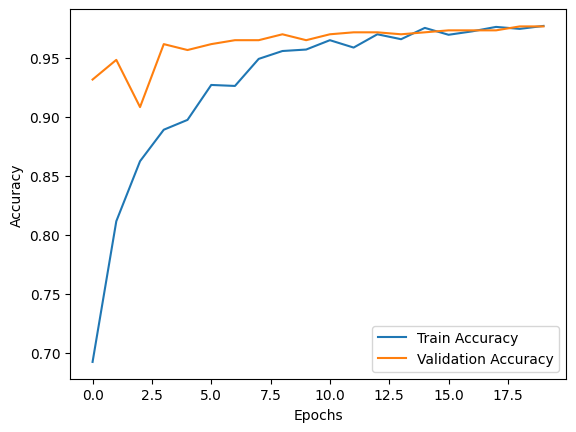

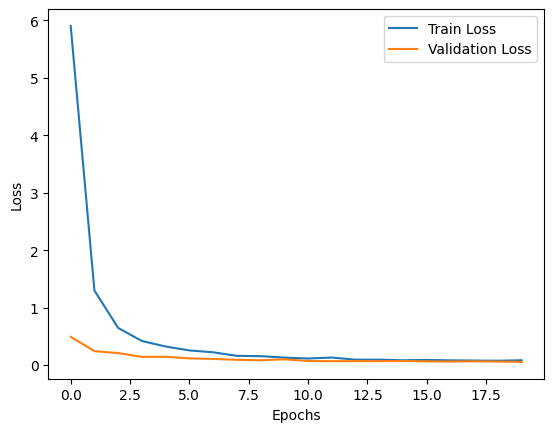

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Save the model
model.save('audio_gender_detection_model.h5')

# Load the model
loaded_model = tf.keras.models.load_model('audio_gender_detection_model.h5')


**Making Predictions**

In [10]:
import numpy as np
import librosa

def preprocess_input(file_path, sr=16000):
    """
    Preprocess an input audio file for prediction.
    """
    # Load and trim the audio
    y, _ = librosa.load(file_path, sr=sr)
    y, _ = librosa.effects.trim(y)

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs.T, axis=0)

    # Reshape for model input
    return mfcc_mean.reshape(1, -1)


In [11]:
# Load the trained model (if not already loaded)
from tensorflow.keras.models import load_model

model = load_model('audio_gender_detection_model.h5')


In [13]:
# Path to the input audio file
input_audio_path = '/content/Audio sample.wav'  # Change this to your audio file path

# Preprocess the audio file
input_features = preprocess_input(input_audio_path)

# Predict the gender
prediction = model.predict(input_features)
predicted_label = 'male' if prediction >= 0.5 else 'female'

print(f"Prediction: {predicted_label}")
print(prediction)

<ipython-input-10-e14901a1e476>:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Prediction: male
[[0.80581266]]
